In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import sklearn.cluster
import mpmath

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

from mpl_toolkits.axes_grid1 import make_axes_locatable

import qc_utils.plot as plot_utils

In [2]:
dx = 15
dz = 15
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

In [3]:
ray_radius = 6
ray_qubit = center_qubit
spectator_patch_data_qubits = []
ray_patch_data_qubits = []
for row in range(7):
    for col in range(15):
        idx = row*15 + col
        if col < 7:
            spectator_patch_data_qubits.append(idx)
        elif col > 7:
            ray_patch_data_qubits.append(idx)

In [4]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [5]:
patch.reset()
baseline_fracs, _, _, baseline_samples = patch.patch.count_detection_events(1e6, return_full_data=True)
baseline_fractions = np.mean(baseline_fracs, axis=0)

patch.force_cosmic_ray(ray_qubit, ray_radius)
ray_fracs, _, _, ray_samples = patch.patch.count_detection_events(1e6, return_full_data=True)
ray_fractions = np.mean(ray_fracs, axis=0)

In [6]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

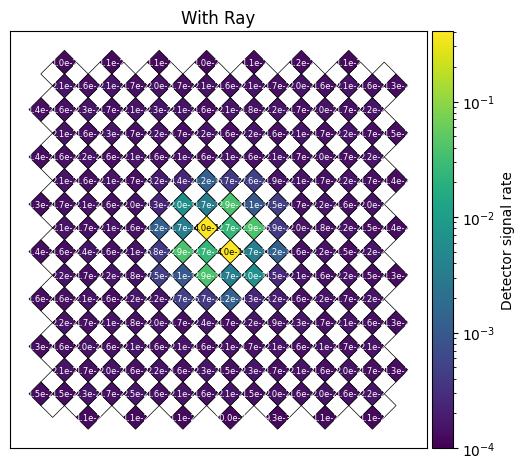

In [7]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-4
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots()

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
_, cbar = patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax, font_size=6, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
# ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax.set_title('With Ray')
cbar.set_label('Detector signal rate')

plt.tight_layout()
plt.savefig('longpatch_ray.png', dpi=300)

In [16]:
temporal_distance = 6*dm
ntrials = 100

rng = np.random.default_rng(1)

In [124]:
convolve_mat = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
], float)

convolve_mat = np.array([
    [1, 1],
    [1, 1],
], float)

fpr = 1e-11

baseline_frac_array = np.zeros((int(np.ceil(len(patch.patch.device)/2)), int(np.ceil(len(patch.patch.device[0])/2))), float)
for i,q in enumerate(syndrome_qubits):
    baseline_frac_array[q.coords[0] // 2, q.coords[1] // 2] = baseline_fractions[i]

convolved_baseline_frac_array = scipy.signal.convolve(baseline_frac_array, convolve_mat, mode='valid')


convolved_thresholds = np.zeros_like(convolved_baseline_frac_array)
for row in range(convolved_thresholds.shape[0]):
    for col in range(convolved_thresholds.shape[1]):
        convolved_thresholds[row, col] = scipy.stats.binom.ppf(1 - fpr, temporal_distance, convolved_baseline_frac_array[row, col])
convolved_thresholds = np.maximum(convolved_thresholds, 1)

/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:90: RuntimeWarning: overflow encountered in _binom_ppf
  return _boost._binom_ppf(q, n, p)


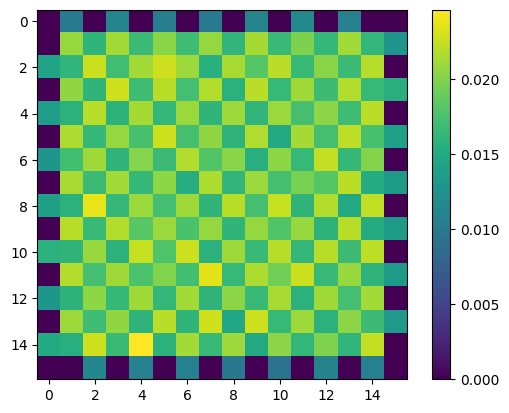

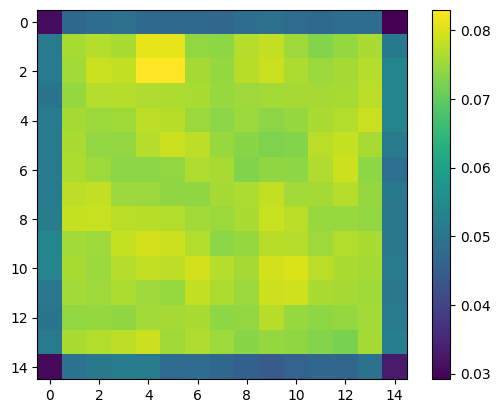

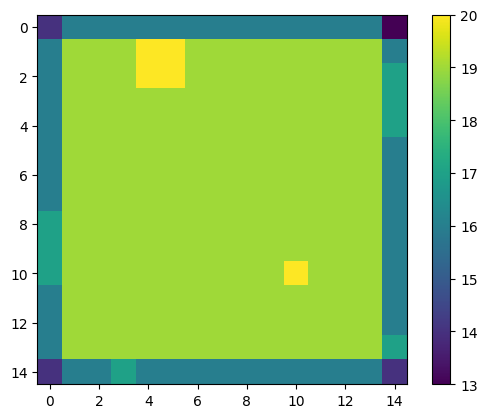

In [125]:
plt.imshow(baseline_frac_array)
plt.colorbar()
plt.show()

plt.imshow(convolved_baseline_frac_array)
plt.colorbar()
plt.show()

plt.imshow(convolved_thresholds)
plt.colorbar()
plt.show()

In [101]:
selected_qubits = np.zeros((ntrials, temporal_distance, len(patch.patch.all_qubits)), bool)
convolved_detectors = np.zeros((ntrials, temporal_distance, convolved_thresholds.shape[0], convolved_thresholds.shape[1]), float)
all_qubit_coords = [[] for _ in range(ntrials)]

# convolved_thresholds = scipy.signal.convolve(threshold_array, convolve_mat,
# mode='same')

for trial in range(ntrials):
    baseline_indices = rng.choice(baseline_samples.shape[0], size=temporal_distance, replace=False)
    baseline_detector_counts = np.mean(baseline_samples[baseline_indices], axis=1)
    ray_indices = rng.choice(ray_samples.shape[0], size=temporal_distance, replace=False)
    ray_detector_counts = np.mean(ray_samples[ray_indices], axis=1)

    detector_counts = np.concatenate((baseline_detector_counts, ray_detector_counts), axis=0)
    for latency in range(temporal_distance):
        detector_sums = np.sum(detector_counts[latency:latency+temporal_distance], axis=0)
        detector_array = np.zeros((int(np.ceil(len(patch.patch.device)/2)), int(np.ceil(len(patch.patch.device[0])/2))), float)
        for i,q in enumerate(syndrome_qubits):
            detector_array[q.coords[0] // 2, q.coords[1] // 2] = detector_sums[i]
        convolved = scipy.signal.convolve(detector_array, convolve_mat, mode='valid')
        convolved_detectors[trial, latency] = convolved

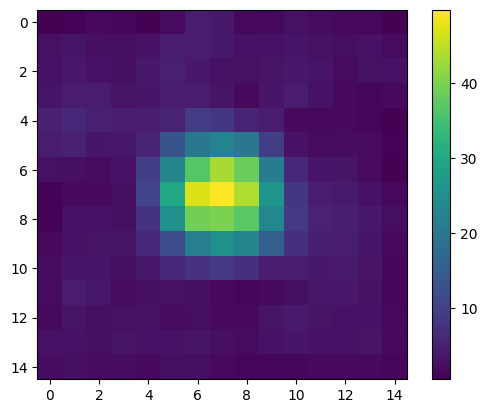

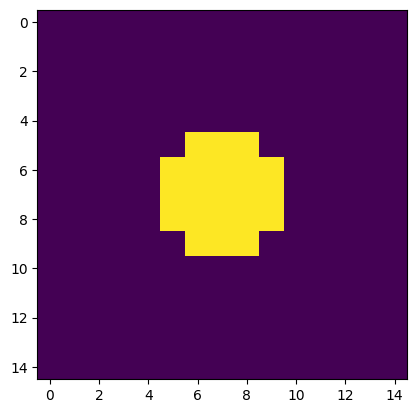

In [111]:
plt.imshow(convolved_detectors[0,-1])
cbar = plt.colorbar()
plt.show()
plt.imshow(convolved_detectors[0,-1] > convolved_thresholds)
plt.show()

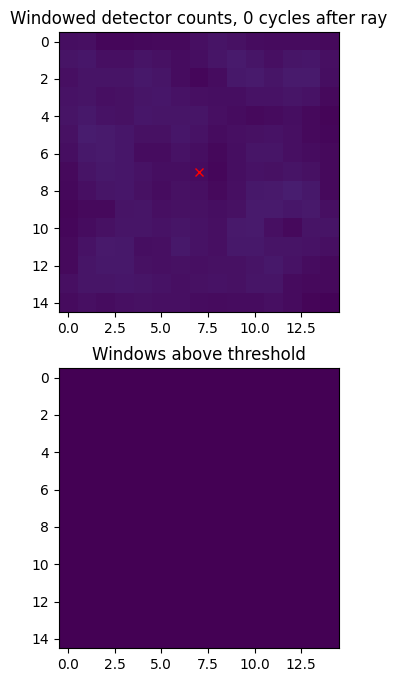

In [140]:
from matplotlib.animation import FuncAnimation

fig,ax = plt.subplots(2,1, figsize=(6,8))

vmax = np.max(convolved_detectors)
cbar = None
def update(i):
    ax[0].clear()
    ax[1].clear()
    if cbar is not None:
        cbar.remove()

    ax[0].imshow(convolved_detectors[0,i], vmin=0, vmax=vmax, cmap='viridis')
    ax[0].plot(center_qubit_coords[1], center_qubit_coords[0], 'rx')
    # cbar = plt.colorbar()
    ax[0].set_title(f'Windowed detector counts, {i} cycles after ray')

    ax[1].imshow(convolved_detectors[0,i] > convolved_thresholds, cmap='viridis')
    ax[1].set_title('Windows above threshold')

anim = FuncAnimation(fig, update, frames=range(temporal_distance), interval=200)
anim.save(f'square_windows.gif')

In [141]:
center_qubit_coords = patch.patch.qubit_name_dict[center_qubit].coords
center_qubit_coords = (7,7)

In [142]:
dist_from_center = np.zeros(dx*dz, float)
trigger_rates = np.zeros((dx*dz, ntrials, temporal_distance), float)
idx = 0
for row in range(dx):
    for col in range(dz):
        q_coords = (row, col)
        idx = row*dz + col
        dist_from_center[idx] = np.linalg.norm(np.array(q_coords) - center_qubit_coords)
        trigger_rates[idx,:,:] = convolved_detectors[:,:,q_coords[0],q_coords[1]]

In [143]:
dist_from_center_x = dist_from_center[qubit_is_x]
dist_from_center_z = dist_from_center[~qubit_is_x]

trigger_rates_x = trigger_rates[qubit_is_x][np.argsort(dist_from_center_x)]
trigger_rates_z = trigger_rates[~qubit_is_x][np.argsort(dist_from_center_z)]

dist_from_center_x = dist_from_center_x[np.argsort(dist_from_center_x)]
dist_from_center_z = dist_from_center_z[np.argsort(dist_from_center_z)]

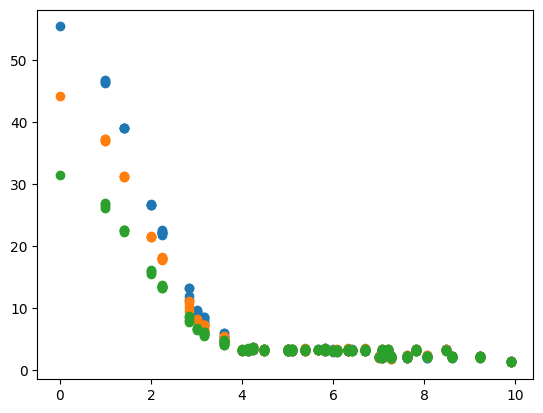

In [146]:
plt.plot(dist_from_center, np.mean(trigger_rates, axis=1)[:,-1], 'o')
plt.plot(dist_from_center, np.mean(trigger_rates, axis=1)[:,-10], 'o')
plt.plot(dist_from_center, np.mean(trigger_rates, axis=1)[:,-20], 'o')
# plt.plot(np.sort(dist_from_center_z), np.interp(dist_from_center_z, dist_from_center_z, np.mean(trigger_rates_z, axis=2)[-1]), 'k--')

## Averaging for each distance

In [157]:
unique_distances = []
unique_trigger_rates = []
counts = []
for i in range(len(dist_from_center)):
    if dist_from_center[i] not in unique_distances:
        unique_distances.append(dist_from_center[i])
        unique_trigger_rates.append(np.mean(trigger_rates, axis=1)[i])
        counts.append(1)
    else:
        idx = unique_distances.index(dist_from_center[i])
        unique_trigger_rates[idx] += np.mean(trigger_rates, axis=1)[i]
        counts[idx] += 1
for i in range(len(unique_distances)):
    unique_trigger_rates[i] /= counts[i]

unique_trigger_rates = np.array(unique_trigger_rates)[np.argsort(unique_distances)]
unique_distances = np.sort(unique_distances)

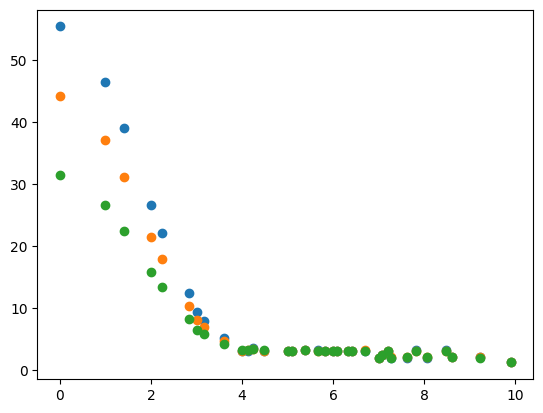

In [160]:
plt.plot(unique_distances, unique_trigger_rates[:,-1], 'o')
plt.plot(unique_distances, unique_trigger_rates[:,-10], 'o')
plt.plot(unique_distances, unique_trigger_rates[:,-20], 'o')